## Fun With Fractals and CuPy on GPU


This is the notebook that was used to generate the results for my blog post at ([TBD]()).  The goal was to find a fun way to demonstrate the power of CuPy, which is effectively a GPU-accelerated clone of Numpy.  CuPy is both powerful, and fits cleanly into the [RAPIDS](https://rapids.ai/) ecosystem, even though it's technically not part of RAPIDS.  

**NOTE**: The interactive visualizations **will not** work on Google Colab; it has a different widget/interaction system than Jupyter.  I ran this on a Linux desktop using JupyterLab 3.0 with the `mpl_interactions` package.  See `requirements.txt`. However most of the notebook will run on Colab, but you might need to remove the `%matplotlib widget` statement at the beginning of the notebook.
 

## Background

[Julia sets](https://en.wikipedia.org/wiki/Julia_set) are fractals based on simple mathematical constructs that produce surprisingly unintutive geometric patterns.  Not only are the patterns visually pleasing, but have infinitely-recursing structure as seen in the following gif from Wikipedia:

![](https://upload.wikimedia.org/wikipedia/commons/a/a4/Mandelbrot_sequence_new.gif)

The animated gif is showing unbounded zooming of the [Mandelbrot set](https://en.wikipedia.org/wiki/Mandelbrot_set), which is closely related to the [Julia Sets](https://en.wikipedia.org/wiki/Julia_set).  You could produce a similar gif of any of the Julia sets produced with this notebook (given a sufficiently wide floating-point datatype).

In this notebook we will:

* Demonstrate how easy it is to write custom CUDA kernels with CuPy
* Demonstrate the absurd speedups you can get on fractal generation
* Generate fractals fast enough to make interactive visuals
* Combine the above with CuPy FFTs to do fractal searches



#### Hardware 

This notebook and timings were  created on a system with th

* **GPU:  NVIDIA GeForce RTX 3090**
* **CPU:  AMD Ryzen 3 5800X**

#### Summary of findings aggregated from running the notebook.
-----
NOTE: The Python & C++ implementations are dumb & naive.  They could probably be optimized to run faster -- but would still never catch up...

| Fractal Timings    | Frames/Sec |
| ----------- |  ------- |
| Python (naive)      |   0.123 FPS |
| C++ (CPU,naive)   |  9.5 FPS |
| CuPy (xfer off GPU) | 2,171 FPS |
| CuPy (stay on GPU) |  24,389 FPS|

-----

In the second half of the notebook, we use FFTs to produce spectrograms to try to find interesting fractals.  It's worth knowing that CuPy has pretty efficient FFTs as well.

| FFT Timings      | Time per FFT (768x768) | Frames/Sec |
| ----------- | ----------- | ------ |
| CPU (Numpy) 2D FFT | 0.00974 sec |  103 FPS |
| GPU (CuPy) 2D FFT (xfer to CPU) | 0.00233 sec | 429 FPS |
| GPU (CuPy) 2D FFT (stay on GPU) | 0.00020 sec |  5,000 FPS |
| ----------- | ----------- | ------ |
| GPU Fractal + FFT + Reduce | 0.00097 sec | 1,036 FPS |

-----

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import time
# import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_interactions import ipyplot as iplt
%matplotlib widget

ModuleNotFoundError: No module named 'mpl_interactions'

In [ ]:
# A super simple timer class for with-statements, computes per-iteration timing
from simple_timer import SimpleTimers

-----

## CuPy Sanity Checks

Let's make sure CuPy was imported properly and finds our GPU.  Run a quick speed test for the lulz.

In [6]:
test_size = 10000

In [ ]:

cupy_mtrx = cp.arange(0, test_size*test_size, dtype='float32')
cupy_mtrx = cupy_mtrx.reshape((test_size, test_size)) / 1024.
print('CuPy Matrix Device:  ', str(cupy_mtrx.device))
print('CuPy Matrix Size:    ', cupy_mtrx.shape)

In [ ]:
# Quick timing test with 4096x4096 matrix multiplication and addition.  Don't
a = cupy_mtrx.copy()
b = cupy_mtrx.copy() + 1.0
c = cp.ones_like(a) * -1.0

n_iter = 100
print(f'(GPU/CuPy) Timing ({test_size}x{test_size})')

with SimpleTimers.new('gpu-mtrx-multiply-add', n_iter):
    for _ in range(n_iter):
        c = a @ b + c

In [ ]:
# Okay let's try it on a CPU, anyway, less iterations
npa = a.get()
npb = b.get()
npc = c.get()

n_iter=5
print(f'(CPU/Numpy) Timing ({test_size}x{test_size})')

with SimpleTimers.new('cpu-mtrx-multiply-add', n_iter):
    for _ in range(n_iter):
        npc = npa @ npb + npc

In [ ]:
gpu_speed = SimpleTimers.get_iter_per_sec('gpu-mtrx-multiply-add')
cpu_speed = SimpleTimers.get_iter_per_sec('cpu-mtrx-multiply-add')
speed_ratio = gpu_speed / cpu_speed
print(f'GPU (CuPy) Speedup over CPU (Numpy) for {test_size}x{test_size} matrices: {speed_ratio:.2f}x')

**With HUGE matrices, you get very impressive speedups using CuPy/GPU.**

-----

# 2. (CPU / Numpy) Fractal Generation Speed Test

Simplest Julia Set computation possible.   All operations _look like_ they could be vectorized, but each point requires a different number of iterations in the escape loop, so it's not as simple as just cramming together the equivalent NumPy ops from the loop.  Effectively, each point in the complex plane has to be simulated individually (which is highly parallelizable, and great for GPUs).

This could clearly be optimized and probably get a sizable speedup on CPU, but we'll see it wouldn't make much of a difference compared to the GPU/CuPy version.

In [7]:
SIZE=768
EPS=1e-6
RE,IM = 0,1  # indexing into a manual complex value (i.e.  c[RE], c[IM] )

In [8]:
# Use a pre-computed mesh as input, created outside this method so it doesn't need to
# be reallocated & recomputed for each call
def cpu_zn2plusc(np_zmesh_re, np_zmesh_im, c_real, c_imag):

    # Create output image buffer
    nr, nc = np_zmesh_re.shape
    out = np.zeros((nr, nc))
    max_escape_iter = 1000
    
    # Iterate over all pixels, using its point in the complex plane as the starting z-value
    for r in range(nr):
        for c in range(nc):
    
            # The starting z-value for pixel[r,c] is z = a + bi
            a = np_zmesh_re[r, c]
            b = np_zmesh_im[r, c]
    
            temp_real, temp_imag = 0,0
    
            for iter in range(1, max_escape_iter):
                if a*a + b*b > 4.0:
                    # Once the squared magnitude is >4.0, it's never coming back
                    break
                else:
                    # (a + bi) * (a + bi) == (a*a - b*b) + (2*a*b)i
                    temp_real = a*a - b*b + c_real
                    temp_imag = 2*a*b + c_imag
                    a = temp_real
                    b = temp_imag
    
            out[r, c] = np.log2(float(iter)) / np.log2(max_escape_iter)

    return out
    

Use `np.meshgrid()` to produce the real and imaginary values for each pixel for which we have to compute the escape time. 

NOTE:  Although Numpy has a complex dtype, CuPy does not.  Thus we will have to break down the problem like this anyway for the GPU implementation.  Using the native complex dtype might give us a mild speedup for the CPU version...

In [9]:
# Constant mesh is the same for all inputs (represent grid in complex plane)
zmesh_real, zmesh_imag = np.meshgrid( 
    np.arange(-2, 2, (4 + EPS) / (SIZE -1)),
    np.arange(-2, 2, (4 + EPS) / (SIZE -1))[::-1])

Let's take a quick look at the mesh.  Complex numbers are `a + bi`.  The left mesh is `a`-values, the right mesh is `b`-values

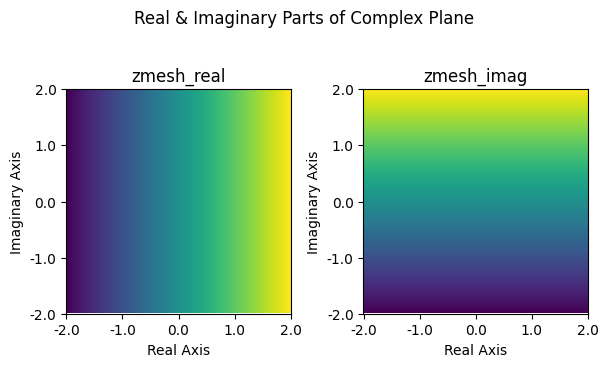

In [10]:
fig,axs = plt.subplots(1,2, figsize=(6,4))
axs[0].imshow(zmesh_real)
axs[0].set_title('zmesh_real')
axs[1].imshow(zmesh_imag)
axs[1].set_title('zmesh_imag')
for i in range(2):
    axs[i].set_xticks(np.arange(0, SIZE+1, SIZE//4))
    axs[i].set_xticklabels(np.arange(-2, 2+EPS, 1))
    axs[i].set_yticks(np.arange(0, SIZE+1, SIZE//4))
    axs[i].set_yticklabels(np.arange(2, -2-EPS, -1))
    axs[i].set_xlabel('Real Axis')
    axs[i].set_ylabel('Imaginary Axis')
fig.tight_layout(pad=0.4)
_ = fig.suptitle('Real & Imaginary Parts of Complex Plane')

NOTE:  `c = -0.8 + 0.156i` is well-known to produce a visually pleasing fractal for f(z) = z<sup>2</sup> + c

In [11]:
# Quick helper function to rescale axes to complex values.  In this case we use r~real, i~imaginary
def relabel_axes(ax, nr=768, rmin=-2, rmax=2, ni=768, imin=-2, imax=2):
    r_width = rmax - rmin
    new_rticks = np.arange(0, nr+1, nr//8, dtype=np.int32).tolist()
    new_rticklabels = [f'{r_width * t / nr + rmin:.1f}' for t in new_rticks]
    ax.set_xticks(new_rticks)
    ax.set_xticklabels(new_rticklabels)
    ax.set_xlabel('Real Axis')
    
    i_width = imax - imin
    new_iticks = np.arange(0, ni+1, ni//8, dtype=np.int32).tolist()
    new_iticklabels = [f'{i_width * t / ni + imin:.1f}' for t in new_iticks]
    ax.set_yticks(new_iticks)
    ax.set_yticklabels(new_iticklabels)
    ax.set_ylabel('Imaginary Axis')
    
    

NameError: name 'SimpleTimers' is not defined

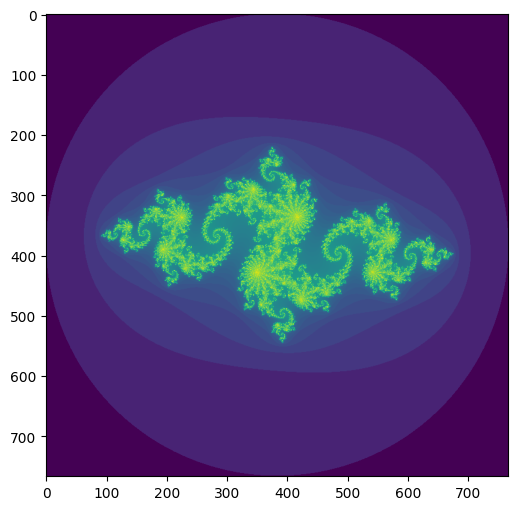

In [13]:
a, b = -0.8, 0.156
# with SimpleTimers.new('cpu-fractal'):
#     cpu_fractal = cpu_zn2plusc(zmesh_real, zmesh_imag, a, b)
#

cpu_fractal = cpu_zn2plusc(zmesh_real, zmesh_imag, a, b)
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(cpu_fractal)
ax.set_title(f'Julia Set for c = {a:.1f} + {b:.3f}i (Numpy: {SimpleTimers.get_sec_per_iter("cpu-fractal"):.2f} sec)')
relabel_axes(ax)

# 3. GPU Implementation

**Notice the switch from `np` methods to nearly identical `cp` methods**

In [ ]:
# Create a GPU/CuPy grid of complex values (`cp.*` instead of `np.*`)
zmesh_re, zmesh_im = cp.meshgrid( 
    cp.arange(-2, 2, (4 + EPS) / SIZE),
    cp.arange(-2, 2, (4 + EPS) / SIZE)[::-1])

### Define the CUDA Kernel using CuPy `ElementwiseKernel`

Everytime we run the following cell, we are generating C++ code that has to be compiled into a CUDA kernel and then uploaded to the GPU.  If we were to create a loop or interactive method with this code inline, we're going to take a devastating performance hit, since it will have to recompile and upload the code for every fractal generation.

So the strategy is to create the `cp.ElementwiseKernel` one time, which compiles and pushes the code to the GPU to be invoked by downstream code repeatedly.  The meshes supplied as the first two arguments were already created on the GPU (in the previous cell), so under the hood it's only passing the existing pointers to GPU memory for those inputs, not copying the data.  The other two arguments are the single complex `c`-value that define the fractal we want to generate.  Therefore, when we invoke this method the only thing being sent to the GPU is a couple of GPU memory pointers and two float32 values.  It doesn't get any more efficient & optimized than that.


In [ ]:
# Define the C++ code to be compiled into the CUDA grid/block kernel
gpu_escape_time_zn_plus_c = cp.ElementwiseKernel(
    'float32 z_mesh_re, float32 z_mesh_im, float32 cReal, float32 cImag',
    'float32 out',
    '''
        int time;

        float tempReal = 0.0;
        float tempImag = 0.0;

        float znReal = z_mesh_re;
        float znImag = z_mesh_im;

        for(time=1; time<1000; time++)
        {
            if(znReal*znReal + znImag*znImag > 4.0)
                break; 
            else
            {
                tempReal = znReal*znReal - znImag*znImag + cReal;
                tempImag = 2*znReal*znImag + cImag;
        
                znReal = tempReal;
                znImag = tempImag;
            }
        }
    
        out = log2f((float)time) / log2f(1000.0f);
    ''',
    'gpu_znplusc')

In [ ]:
# Create the mesh inputs directly on the GPU with cp.meshgrid(...)
zmesh_re, zmesh_im = cp.meshgrid(cp.arange(-2, 2+EPS, 4.0/(SIZE-1), dtype=cp.float32),
                                 cp.arange(-2, 2+EPS, 4.0/(SIZE-1), dtype=cp.float32))

# A quick test to confirm it runs and produces the output shape we expected
out = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, -0.8, 0.156)
print('Test run output shape:', out.shape)

In [ ]:
# Show some samples
c_vals = [(-0.8,   0.156),
          (-0.2,  -0.4),
          (-0.4,   0.6),
          ( 0.4,  -0.1)]
          
fig,axs = plt.subplots(2,2, figsize=(8,8))
for i, (a,b) in enumerate(c_vals):
    out = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, a, b)
    axs[i//2][i%2].imshow(out.get())
    axs[i//2][i%2].set_title(f'c-value = {a:.2f} + {b:.2f}i')
    axs[i//2][i%2].axis('off')


In [ ]:
c_vals = [(-0.8,   0.156),
          (-0.2,  -0.4),
          (-0.4,   0.6),
          ( 0.4,  -0.1)]
          

fig,axs = plt.subplots(1,4, figsize=(16, 4))
for i, (re, im) in enumerate(c_vals):
    out = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, re, im)
    axs[i].imshow(out.get())
    axs[i].set_title(f'c-value = {re:.2f} + {im:.2f}i')
    axs[i].axis('off')


## GPU Timing Tests

The following timing computes thousands of fractals with different `c`-values, but it leaves the data on the GPU.  This will emphasize the raw computation speed of the GPU, even though some applications would have to transfer the result from the GPU back to the host/CPU.

In [ ]:
# GPU timing test params
LIM = 1.0
GRID = 128

In [ ]:
# This is solely for timing raw fractal computation (does not leave GPU)
print(f'GPU Timing:  {SIZE}x{SIZE} fractals; no xfer to CPU')
with SimpleTimers.new('gpu-fractal-no-xfer', n_iter=GRID*GRID):
    for j,c_re in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
        for i,c_im in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
            out = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, c_re, c_im)


For comparison, this is the same computation but with `.get()` on each result, which transfers the data back to the host/CPU.  We should see a dramatic performance hit, though it will still be way faster than the CPU version

In [ ]:
print(f'GPU Timing:  {SIZE}x{SIZE} fractals; with overhead of xfer to CPU after each (no batching)')

host_var = None
with SimpleTimers.new('gpu-fractal-xfer-to-host', n_iter=GRID*GRID):
    for j,c_re in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
        for i,c_im in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
            host_var = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, c_re, c_im).get()

host_var = None

### Speed Summary

In [ ]:
display_table = [ \
    ['CPU / Numpy', SimpleTimers.get_iter_per_sec('cpu-fractal')],
    ['CPU / C++', 10.1],  # from a naive C++ implementation on 768x768 fractals
    ['GPU / CuPy (xfer to host)', SimpleTimers.get_iter_per_sec('gpu-fractal-xfer-to-host')],
    ['GPU / CuPy (stay on GPU)', SimpleTimers.get_iter_per_sec('gpu-fractal-no-xfer')],
]

for txt,fps in display_table:
    print((txt+':').ljust(30), f'{fps:.2f}'.rjust(10), 'frames/sec')

print('\nNote: C++ timing was based on a naive C++ implementation not shown here')

-----

# 4. Interactive Fractals!

We see that each (complex) value of `c` in `f(z) = z^2 + c` produces a different fractal:

![](https://areiner-image-share.s3.amazonaws.com/julia_set_search.png)

Since we can generate fractals so quickly, let's make an interactive fractal viewer!



In [ ]:
# This really has to be defined inline in the notebook to work with mpl-interactions
class FractalExplorer:
    def __init__(self, kernel, figure, im, txt, clim=2.0, img_size=SIZE):
        self.is_pressed = False
        self.clim = clim
        self.kernel = kernel
        self.img_size = img_size
        self.figure = figure
        self.im = im
        self.txt = txt

    def connect(self):
        self.cidpress = self.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidrelease = self.figure.canvas.mpl_connect('button_release_event', self.on_release)
        self.cidmotion = self.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event):
        self.is_pressed = True
        self.on_motion(event)

    def on_motion(self, event):
        if not self.is_pressed:
            return
        
        c_re = (event.xdata / self.img_size) * (2*self.clim) - self.clim
        c_im = (event.ydata / self.img_size) * (2*self.clim) - self.clim
        self.txt.set_text(f'c = {c_re:.3f} + {-c_im:.3f}i')
        self.im.set_data(self.kernel(zmesh_re, zmesh_im, c_re, -c_im).get())
        self.im.draw()

    def on_release(self, event):
        self.is_pressed = False

    def disconnect(self):
        self.figure.canvas.mpl_disconnect(self.cidpress)
        self.figure.canvas.mpl_disconnect(self.cidrelease)
        self.figure.canvas.mpl_disconnect(self.cidmotion)
        self.figure = None
        self.im = None

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, -0.8, 0.156).get())
txt = ax.text(5, 25, c='w', s='c = -0.800 + 0.156i')
relabel_axes(ax)
fs = FractalExplorer(gpu_escape_time_zn_plus_c, fig, im, txt, clim=1.2)
fs.connect()

For reference, here's a few common `c`-values that produce visually-pleasing Julia Set fractals that you can try to mouse to, above:

```
(c_real, c_imag) = (-0.8, 0.16)
(c_real, c_imag) = (-0.76, 0.10)
(c_real, c_imag) = (-0.4, 0.60)
(c_real, c_imag) = (0.32, -0.5)
```

## Create a desktop wallpaper of your fractal!

In [ ]:
# Create a desktop wallpaper
size = (2540, 1440)
colormap_name = 'hot'

# Need to update our mesh creation to create custom, non-square fractals
step = 4.0 / max(size) 
lims = [s*step/2.0 for s in size]
mesh_wp_re, mesh_wp_im = cp.meshgrid(cp.arange(-lims[0], lims[0]+EPS, step, dtype=cp.float32),
                                     cp.arange(-lims[1], lims[1]+EPS, step, dtype=cp.float32))

# Get the last-chosen c-value from the text box (I had trouble doing this in more elegant ways ... ?)
txt_parts = txt.get_text().split(' ')
c_re = float(txt_parts[2])
c_im = float(txt_parts[4][:-1])
print(f'Value from mouse selection above: {c_re:.3f} + {c_im:.3f}i')

fractal = gpu_escape_time_zn_plus_c(mesh_wp_re, mesh_wp_im, c_re, c_im).get()
norm = plt.Normalize(vmin=fractal.min(), vmax=fractal.max())
image = plt.get_cmap(colormap_name)(norm(fractal))
fig,ax = plt.subplots(figsize=(8, 8 * size[1]/size[0]))
ax.imshow(image)
save_file = f'wallpaper_fractal_{c_re:.3f}_{c_im:.3f}.png'
ax.set_title(f'Your Fractal Wallpaper is Ready!  {save_file}')

# Truncate the image if it's slightly larger than intended
plt.imsave(save_file, image[:size[1], :size[0], :])


-----

------

## 5. GPU Fractal Search!

Let's take this a step further: rather than manually searching for good fractals using the mouse and our eyeballs, let's define a scoring function that is correlated with "good" fractals and search through all possible points that we would otherwise search with our mouse.

My hypothesis is that the "good" fractals have the more high-frequency components than the "bad" fractals.  So we can create a scoring function based on using CuPy's GPU-accelerated [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform).  High density at the edges of the spectrogram indicate large frequency componenets. 

The beauty of this solution is that we can apply the FFT to the generated fractal and then compute its score, without any data leaving the GPU.  


### Simple data pipeline through the GPU

For each fractal (`c`-value), only a tiny amount of data is uploaded to the GPU to kick off the computation, then only the `float32` score is returned. 

<img src="https://areiner-fractal-resources.s3.amazonaws.com/fractal_cpu_gpu_diagram.png" width="800">

(Note: the diagram is an oversimplification, but it accurately portrays the high efficiency of the pipeline)

In [ ]:
# Just testing that FFT works and what it looks like (CPU/Numpy)
fft_domain = np.fft.fftshift(np.fft.fft2(cpu_fractal))
fig,ax = plt.subplots(figsize=(4,4))
ax.imshow(np.log10(np.abs(fft_domain)))
_ = plt.title('log-FFT of a "Good" Fractal')

In [ ]:
SIZE = 768
zmesh_re, zmesh_im = cp.meshgrid(cp.arange(-2, 2+EPS, 4.0/(SIZE-1), dtype=cp.float32),
                                 cp.arange(-2, 2+EPS, 4.0/(SIZE-1), dtype=cp.float32))

# The above meshgrid is actually resuable to compute a absolute-value-based score mask
score_mask = zmesh_re*zmesh_re + zmesh_im*zmesh_im

# "kernel" is the CuPy complex function -- we make it an input so we can repeat this for another
# fractal type, later.
def evaluate_fractal(kernel, zmesh_real, zmesh_imag, c_real, c_imag, score_mask):
    fractal = kernel(zmesh_real, zmesh_imag, c_real, c_imag)
    spectral = cp.abs(cp.fft.fftshift(cp.fft.fft2(fractal)))
    score = np.log2(cp.sum(score_mask * spectral))
    return score


In [ ]:
good_fractal = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, -0.8, 0.156)
bad_fractal = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, -0.2, -0.4)

good_log_fft = cp.log(cp.abs(cp.fft.fftshift(cp.fft.fft2(good_fractal))))
bad_log_fft = cp.log(cp.abs(cp.fft.fftshift(cp.fft.fft2(bad_fractal))))

good_score = evaluate_fractal(gpu_escape_time_zn_plus_c, zmesh_re, zmesh_im, -0.8, 0.156, score_mask)
bad_score = evaluate_fractal(gpu_escape_time_zn_plus_c, zmesh_re, zmesh_im, -0.2, -0.4, score_mask)

fig, axs =plt.subplots(2,2, figsize=(8,8))

axs[0][0].imshow(good_fractal.get())
axs[0][0].set_title('Good fractal: -0.8 + 0.156i')

axs[0][1].imshow(bad_fractal.get())
axs[0][1].set_title('"Bad" fractal: -0.2 + -0.4i')

axs[1][0].imshow(good_log_fft.get())
axs[1][0].set_title(f'Good FFT, score={good_score:.1f}')

axs[1][1].imshow(bad_log_fft.get())
axs[1][1].set_title(f'Bad FFT, score={bad_score:.1f}')

for i in range(4):
    axs[i//2][i%2].axis('off')



In absoute terms, it looks like all fractals have a lot of high-frequency components.  But there is a visual difference between them.  And we'll see that it's enough to produce interesting results.
   

In [ ]:
LIM = 1.6
GRID = 256
STEP = 2*(LIM + EPS) / (GRID - 1)
c_map = np.zeros(shape=(GRID, GRID), dtype='float')

with SimpleTimers.new('gpu-fractal-fft-score', n_iter=GRID*GRID):
    for j,c_re in enumerate(np.arange(-LIM, LIM, STEP)):
        for i,c_im in enumerate(np.arange(-LIM, LIM, STEP)):
            c_map[i,j] = evaluate_fractal(gpu_escape_time_zn_plus_c, zmesh_re, zmesh_im, c_re, c_im, score_mask)


In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
disp_good_c_map = c_map[2:-2, 2:-2]
ax.imshow(disp_good_c_map)

ax.set_title('FFT-based Score for each c-value')
relabel_axes(ax, nr=256, ni=256, rmin=-1.6, rmax=1.6, imin=-1.6, imax=1.6)

## The Good-Fractal Map is ... a fractal ?!
It turns out that the map of `c`-values that produce high quality fractals is another fratal!  Specifically, it's the Mandelbrot set.  Here's a high-res version from wikipedia.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Mandel_zoom_00_mandelbrot_set.jpg/322px-Mandel_zoom_00_mandelbrot_set.jpg)

(Source: From Wikipedia)

Might as well check the fractal at the point with the most high-frequency...

In [ ]:
print('C-value map:', c_map.shape)
lin_max = np.argmax(c_map)
j, i = lin_max // GRID, lin_max % GRID
highest_freq_fractal = gpu_escape_time_zn_plus_c(zmesh_re, zmesh_im, -LIM+i*STEP, -LIM+j*STEP)
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(highest_freq_fractal.get())
ax.set_title('Julia Set with Most High-Frequency Components')
relabel_axes(ax)


-----
## Cubic Fractal

Another common fractal is f(z) = z<sup>3</sup> + c

We should be able to define it the same way and repeat the search.

In [ ]:

max_iter_escape = 1000
gpu_escape_time_zn3plusc = cp.ElementwiseKernel(
        'float32 mesh_re, float32 mesh_im, float32 cReal, float32 cImag',
        'float32 out',
        f'''
            int time = 0;

            float tempReal = 0.0;
            float tempImag = 0.0;

            float a = mesh_re;
            float b = mesh_im;
            float magnitude = 0.0;

            for(time=1; time<{max_iter_escape}; time++)
            {{
                magnitude = a*a + b*b;
                if(magnitude < 4.0)
                {{
                    tempReal = a*a*a - 3*a*b*b + cReal;
                    tempImag = 3*a*a*b - b*b*b + cImag;
            
                    a = tempReal;
                    b = tempImag;
                }}
                else
                    break;
            }}
        
            out = log2f((float)time) / log2f((float){max_iter_escape});
        ''',
        'escape_time_zn3minus1')

Equation: z<sup>3</sup> + c

Some good looking values:
```
c ==  0.470 - 0.580i
c == -0.560 + 0.230i
c == -0.550 + 0.292i
c ==  0.535 - 0.378i
c == -0.465 - 0.028i
```

In [ ]:

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(gpu_escape_time_zn3plusc(zmesh_re, zmesh_im, -0.56, 0.23).get())
txt = ax.text(5, 25, c='w', s='c = -0.56 + 0.23i')
ax.set_xticks(np.arange(0, SIZE+1, SIZE//4))
ax.set_xticklabels(np.arange(-2, 2+EPS, 1))
ax.set_yticks(np.arange(0, SIZE+1, SIZE//4))
ax.set_yticklabels(np.arange(-2, 2+EPS, 1))
ax.set_xlabel('Real Axis')
ax.set_ylabel('Imaginary Axis')
fs3 = FractalExplorer(gpu_escape_time_zn3plusc, fig, im, txt, clim=1.0)
fs3.connect()

In [ ]:
size = (2540, 1440)
colormap_name = 'hot'

step = 4.5 / max(size) 
lims = [s*step/2.0 for s in size]
offs = 0.0  # shifts the window vertical due to cubic fractals being vertically skewed
zmesh_wp_re, zmesh_wp_im = cp.meshgrid(cp.arange(-lims[0], lims[0]+EPS, step, dtype=cp.float32),
                                     cp.arange(-lims[1]-offs, lims[1]+EPS, step, dtype=cp.float32))

# Get the last-chosen c-value from the text box (I had trouble doing this other ways ... ?)
txt_parts = txt.get_text().split(' ')
c_re = float(txt_parts[2])
c_im = float(txt_parts[4][:-1])
print(f'Value from mouse selection above: {c_re:.3f} + {c_im:.3f}i')

fractal = gpu_escape_time_zn3plusc(zmesh_wp_re, zmesh_wp_im, c_re, c_im).get()
norm = plt.Normalize(vmin=fractal.min(), vmax=fractal.max())
image = plt.get_cmap(colormap_name)(norm(fractal))
fig,ax = plt.subplots(figsize=(8, 8 * size[1]/size[0]))
ax.imshow(image)
ax.set_title('Your Fractal Wallpaper is Ready!  (wallpaper_fractal.png)')
plt.imsave('wallpaper_fractal_zn3p1.png', image[:size[1], :size[0], :])

## "Good Fractal Map" for the z<sup>3</sup> + c Variant

In [ ]:
z3_c_map = np.zeros(shape=(GRID, GRID), dtype='float')

t_start = time.time()
for j,c_re in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
    for i,c_im in enumerate(np.arange(-LIM, LIM, 2*(LIM + EPS) / (GRID - 1))):
        z3_c_map[i,j] = evaluate_fractal(gpu_escape_time_zn3plusc, zmesh_re, zmesh_im, c_re, c_im, score_mask)

print(f'Evaluated {GRID*GRID:,d} in {time.time()-t_start:.1f} seconds')
time_per_fractal = (time.time() - t_start) / (GRID * GRID)
print(f'GPU - Time to compute each {SIZE}x{SIZE} fractal, FFT, reduce: {time_per_fractal:.4f} sec')

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
z3_disp_good_c_map = z3_c_map[2:-2, 2:-2]
ax.imshow(z3_disp_good_c_map)


In [ ]:
lin_max = np.argmax(c_map)
j, i = lin_max // GRID, lin_max % GRID
highest_freq_fractal = gpu_escape_time_zn3plusc(zmesh_re, zmesh_im, -LIM+i*STEP, -LIM+j*STEP)
fig,ax = plt.subplots(figsize=(8,8))
_ = ax.imshow(highest_freq_fractal.get())

-----

## FFT Timings & CPU/GPU-Agnostic Code

We combine this timing code with an demonstration of how to write GPU-agnostic code


In [ ]:
# "xp" is used when it could be CuPy (cp) or NumPy (np) depending on inputs
num_test = 100
size = 1024

def test_fft_module(random_input, n_test):
    xp = cp.get_array_module(random_input)
    modname = str(xp).split(' ')[1].strip('"\'')
    
    with SimpleTimers.new(f'{modname}-fft', n_iter=n_test):
        for i in range(n_test):
            out = xp.fft.fft2(random_input[i, :, :])
    
test_fft_module(np.random.uniform(size=(num_test, size, size)), num_test)
test_fft_module(cp.random.uniform(size=(num_test, size, size)), num_test)

# In other cases, we would make the function take an array argument and use
#   xp = cp.get_array_module(my_array)

cpu_speed = SimpleTimers.get_iter_per_sec('numpy-fft')
gpu_speed = SimpleTimers.get_iter_per_sec('cupy-fft')
speed_ratio = gpu_speed / cpu_speed
print(f'GPU Speedup for {size}x{size} FFTs: {speed_ratio:.2f}')

![](../../../fractal_explorer_small.gif)